# MP6: IIR Filters: Notch Filters and Resonant Filters

Audio recordings sometimes have 60Hz hum noise, caused by leaving the microphone cable to close to a power line.  This MP will explore methods for getting rid of the hum noise, especially the low-frequency harmonics.  This MP was originally designed by Prof. Doug Jones at the University of Illinois.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure
import wave
%matplotlib inline

In [2]:
import importlib
import submitted
importlib.reload(submitted)

<module 'submitted' from '/home/jsb/_BACKUP/_School/2024 3Fall/ECE 401/mp6/submitted.py'>

## Part 0. Exploring the Data

This MP will explore one audio recording in detail, so that you can see where the low-frequency peaks are.  The main peak, at 120Hz, could easily be filtered out from a large number of audio files, all at once.

In [3]:
with wave.open('input.wav','rb') as w:
    fs = w.getframerate()
    nsamps = w.getnframes()
    x = np.frombuffer(w.readframes(nsamps),dtype=np.int16).astype('float32')

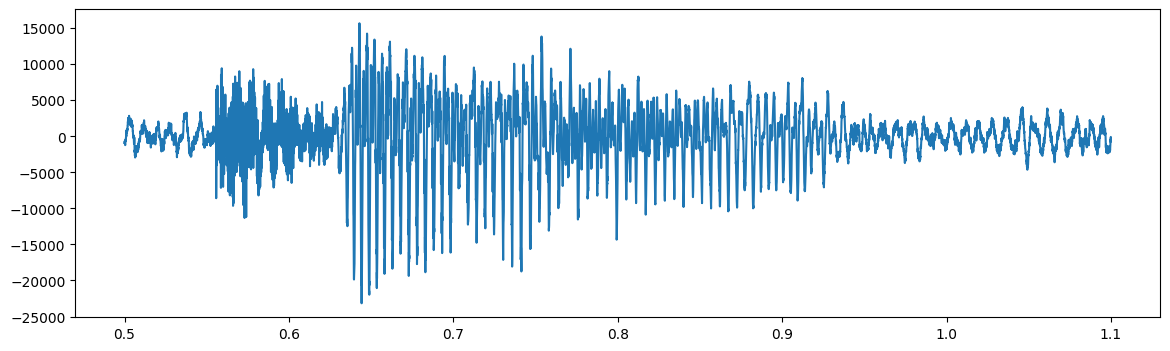

In [4]:
t = np.linspace(0,nsamps/fs,nsamps)
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(t[(0.5<t)&(t<1.1)],x[(0.5<t)&(t<1.1)])

Notice, in the waveform above, there is a periodic component in the "silence" before and after the speech begins.  There seem to be five or six periods in 0.05sec, so maybe the period is around 0.01sec, or around 100Hz.  We can listen to it using the following code:

In [5]:
import IPython.display as ipd
ipd.Audio(x, rate=fs)

## How to debug

Rather than printing every plot using separate blocks for both the distributed solution and your solution, instead, each of the following blocks will include lines to plot either one or the other.  In order to switch between your solution and the distributed solution, you'll need to comment out the other one.

In [6]:
import h5py
solutions = h5py.File('solutions.hdf5','r')

## Part 1. Searching for the noise peaks

First, let's plot a spectrum, and try to find the frequencies of the noise components.

In [7]:
importlib.reload(submitted)
help(submitted.todo_spectrum)

Help on function todo_spectrum in module submitted:

todo_spectrum(x)
    Input:
    x (N) - a waveform
    Output:
    spec (N) - magnitude spectrum at N frequencies between 0 and fs, not including fs.



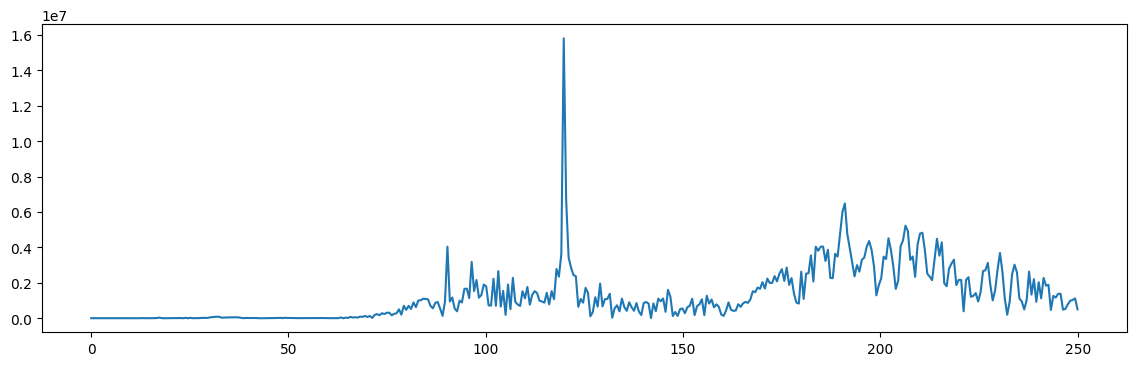

In [8]:
importlib.reload(submitted)
spec=submitted.todo_spectrum(x)
#spec = solutions['spec'][:]
f = np.linspace(0,fs,nsamps,endpoint=False)
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(f[f<250],spec[f<250])
#ax.plot(f,spec)

* It looks like there's a huge power-line noise component at about 120Hz.  
* There doesn't seem to be any 60Hz component; the recording device seems to have filtered out all energy below about 80Hz.  
* There is also energy at about 180Hz, which might be the third harmonic of the power line noise, but it might also be the pitch of a female talker.  Let's leave that energy in the signal.
* Instead, let's eliminate three of the other small peaks that occur between 90Hz and 120Hz.
* We'll use the "todo_findpeak" function to find the frequencies of those peaks (if you've written it).

In [9]:
importlib.reload(submitted)
help(submitted.todo_findpeak)

Help on function todo_findpeak in module submitted:

todo_findpeak(spec, fs, flo, fhi)
    Input:
    spec (N) - magnitude spectrum at N frequencies between 0 and fs, not including fs.
    fs (scalar)  - sampling frequency
    flo (scalar) -  low end of the frequency range to search
    fhi (scalar) - high end of the frequency range to search
    Output:
    fpeak (scalar) - frequency of the highest-magnitude spectral sample, in Hertz



In [19]:
importlib.reload(submitted)
noise1 = submitted.todo_findpeak(spec, fs, 0, 100)
noise2 = submitted.todo_findpeak(spec, fs, noise1+1, 100)
noise3 = submitted.todo_findpeak(spec, fs, 100, 110)
noise4 = submitted.todo_findpeak(spec, fs, 100, 150)
noise5 = submitted.todo_findpeak(spec, fs, 150, 200)
freqs = np.array([noise1,noise2,noise3,noise4,noise5])
#freqs = solutions['freqs'][:]
print(freqs)

[ 90.28444206  96.42624084 103.18221949 119.7650762  191.00994204]


## Part 2. Creating the notch filters

We'll create four notch filters: one for each of the frequencies we want to eliminate.  For each notch filter, we need to create zeros and poles for the Z transform, then convert them to filter coefficients.

First, we'll find the zeros.  Remember that the zeros of the filter are at:

$$r_{0,k} = e^{j2\pi f_k/F_s},~~~r_{1,k}=r_{0,k}^*$$

In [20]:
importlib.reload(submitted)
help(submitted.todo_zeros)

Help on function todo_zeros in module submitted:

todo_zeros(freqs, fs)
    Input:
    freqs (nfreqs) - an array of frequencies you want zeroed out, in Hertz
    fs (scalar) - sampling frequency, in Hertz
    Output:
    r (2,nfreqs) - an array of complex zeros on the unit circle, in complex conjugate pairs



In [24]:
importlib.reload(submitted)
r = submitted.todo_zeros(freqs,fs)
#z = solutions['z'][:]
print(np.angle(r)*fs/(2*np.pi))

[[  90.28444206   96.42624084  103.18221949  119.7650762   191.00994204]
 [ -90.28444206  -96.42624084 -103.18221949 -119.7650762  -191.00994204]]


Now let's find the poles.  Remember that, for a notch filter, the poles should be at the same frequencies as the zeros, but shifted to the inside of the unit circle a little:

$$p_{0,k} = ar_{0,k},~~~p_{1,k}=p_{0,k}^*,$$

where $a$ is some number such that the resulting frequency response has a bandwidth of $BW$ Hertz.

In [25]:
importlib.reload(submitted)
help(submitted.todo_poles)

Help on function todo_poles in module submitted:

todo_poles(r, BW, fs)
    Input:
    r (2,nfreqs) - an array of complex zeros on the unit circle, in complex conjugate pairs
    BW (scalar) - desired bandwidth, in Hertz
    fs (scalar) - sampling frequency, in Hertz
    Output:
    p (2,nfreqs) - an array of complex poles with bandwidth BW, in complex conjugate pairs



In [40]:
importlib.reload(submitted)
p = submitted.todo_poles(r,20,fs)
#p = solutions['p'][:]
print(np.abs(p))

16000
[[[0.99608071 0.99608071 0.99608071 0.99608071 0.99608071]
  [0.99608071 0.99608071 0.99608071 0.99608071 0.99608071]]

 [[0.99608071 0.99608071 0.99608071 0.99608071 0.99608071]
  [0.99608071 0.99608071 0.99608071 0.99608071 0.99608071]]]


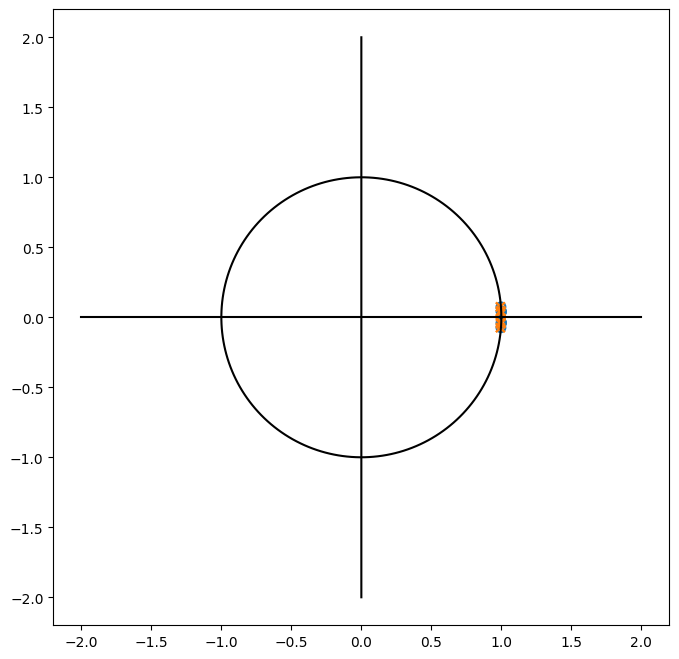

In [41]:
def pole_zero_plot(r,p):
    fig=plt.figure(figsize=(10,8))
    ax=fig.subplots()
    ax.plot([0,1e-6],[-2,2],'k-',[-2,2],[0,0],'k-')  # plot the axes
    omega = np.linspace(0,2*np.pi,200)
    ax.plot(np.cos(omega),np.sin(omega),'k-') # plot the unit circle
    ax.set_aspect('equal') # make it look like a circle
    zeromarker = matplotlib.markers.MarkerStyle(marker='o',fillstyle='none')
    polemarker = matplotlib.markers.MarkerStyle(marker='x',fillstyle='none')
    ax.scatter(x=np.real(r),y=np.imag(r),s=40,marker=zeromarker)
    ax.scatter(x=np.real(p),y=np.imag(p),s=40,marker=polemarker)
    return(ax)

ax=pole_zero_plot(r,p)


At that scale, the poles and zeros are all right on top of each other!  Let's try to zoom in.

(-0.08, 0.08)

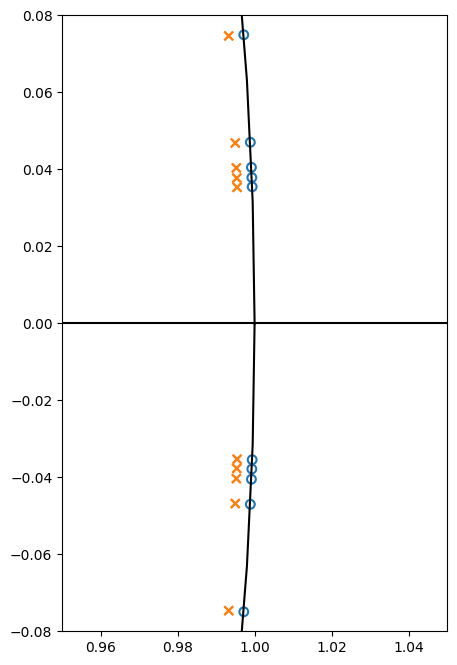

In [42]:
ax=pole_zero_plot(r,p)
ax.set_xlim([0.95,1.05])
ax.set_ylim([-0.08,0.08])


Finally, let's create the filter coefficients.  There are four filters, each of which has feedforward coefficients (b[:,k]) and feedback coefficients (a[:,k]):

$$H(z) = \prod_{k=1}^4 H_k(z)$$

$$H_k(z) = \frac{B_k(z)}{A_k(z)}$$

**WARNING:** The definition of $A(z)$ in the MP are a little different from what we did in lecture.  In lecture, and in this MP, the numerator polynomial is defined as:

$$B_k(z) = (1-r_{0,k}z^{-1})(1-r_{1,k}z^{-1}) = b_{0,k} + b_{1,k}z^{-1} + b_{2,k} z^{-2}$$

For the MP, we will define $A(z)$ with the same coefficient signs as $B(z)$, i.e., $A(z)$ is defined as:

$$A_k(z) = (1-p_{0,k}z^{-1})(1-p_{1,k}z^{-1}) = a_{0,k} + a_{1,k}z^{-1} + a_{2,k} z^{-2}$$

(In lecture we defined $A(z)$ with coefficients $a_1$ and $a_2$ that had the opposite sign from the signs shown above.  Can you see why?)

Because the MP is designing $A(z)$ and $B(z)$ symmetrically, as shown above, it is possible to use the same function to calculate either set of coefficients.  Let's call that function `todo_coefficients`:

In [43]:
importlib.reload(submitted)
help(submitted.todo_coefficients)

Help on function todo_coefficients in module submitted:

todo_coefficients(r)
    Input:
    r (2,nfreqs) - an array of complex roots, in complex conjugate pairs
    Output:
    b (3,nfreqs) - an array of second-order polynomial coefficients, one per complex root pair



In [ ]:
importlib.reload(submitted)
a = submitted.todo_coefficients(p)
#a = solutions['a'][:]
b = submitted.todo_coefficients(r)
#b = solutions['b'][:]
for whichfreq in range(4):
    print('For frequency',whichfreq,'numerator coefficients are',b[:,whichfreq])
    print('   and denominator coefficients are',a[:,whichfreq])
    
print('a is',a)
print('b is', b)

0


TypeError: list indices must be integers or slices, not tuple

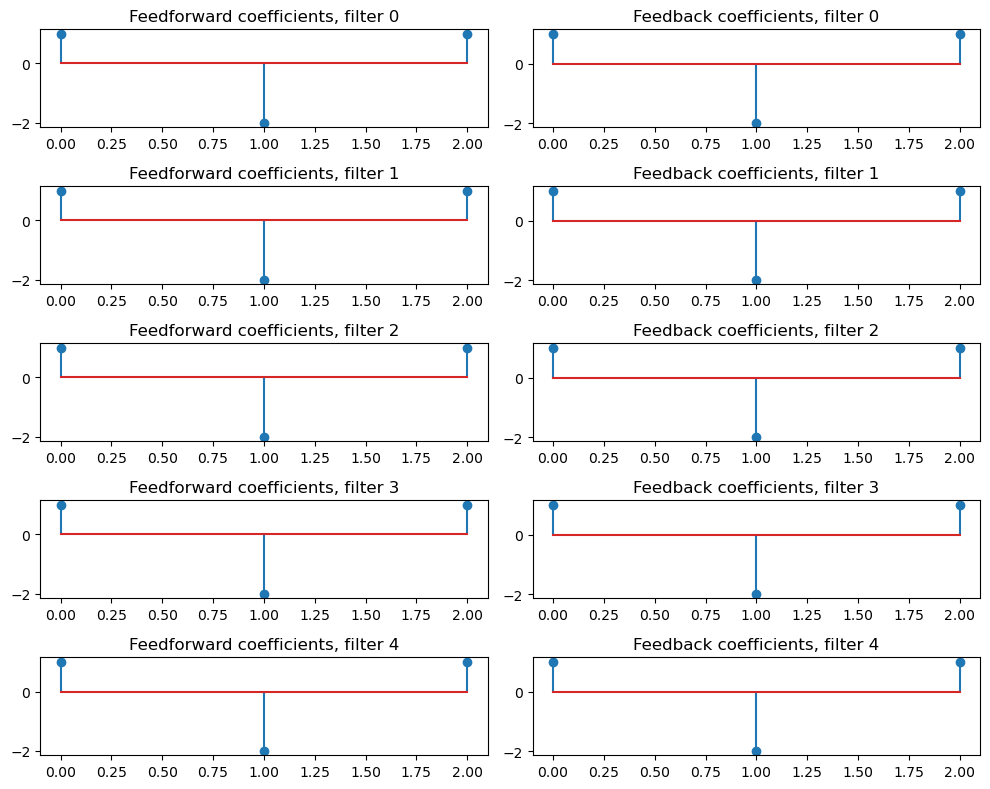

In [ ]:
fig = plt.figure(figsize=(10,8))
axs=fig.subplots(len(freqs),2)
for row in range(len(freqs)):
    axs[row,0].stem(b[:,row])
    axs[row,0].set_title('Feedforward coefficients, filter %d'%(row))
    axs[row,1].stem(a[:,row])
    axs[row,1].set_title('Feedback coefficients, filter %d'%(row))
fig.tight_layout()

## Part 3. Filtering out the noise

Let's plot the frequency response that we would get by running all four filters, one after the other.

First, let's plot the frequency responses that we get from each of the second-order notch filters separately.  Remember that these are:

$$H_k(\omega)=\left. H_k(z)\right|_{z=e^{j\omega}}=\frac{B(e^{j\omega})}{A(e^{j\omega})}$$

Let's plot this for the following frequencies: $\omega\in\left\{0,\frac{2\pi}{N},\frac{4\pi}{N},\ldots,\frac{2\pi(N-1)}{N}\right\}$.

In [ ]:
importlib.reload(submitted)
help(submitted.todo_freqresponse)

Help on function todo_freqresponse in module submitted:

todo_freqresponse(a, b, N, version='right')
    Input: 
    a (3) - feedback coefficients.  You may assume a[0]=1.
    b (3) - feedforward coefficients.  You may assume b[0]=1.
    N (scalar) - number of samples of the frequency response to compute
    Output: 
    omega (N) - frequencies linearly spaced between 0 and 2pi, not including 2pi.
    H (N) - B(e^{jw})/A(e^{jw}) evaluated at the frequencies in the vector omega.



We can calculate the total frequency response by multiplying all four component frequency responses together:
$$H(\omega) = \prod_{k=1}^4 H_k(\omega)$$

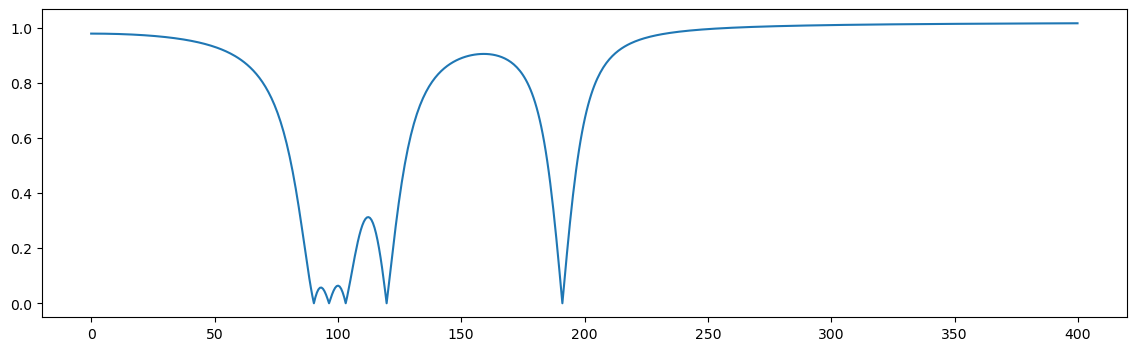

In [ ]:
importlib.reload(submitted)
H = np.ones(nsamps,dtype='complex')
for k in range(len(freqs)):
    omega, Hnew = submitted.todo_freqresponse(a[:,k],b[:,k],nsamps)
    H *= Hnew
#H = solutions['H'][:]
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
plt.plot(f[f<400],np.abs(H[f<400]))
#plt.plot(f,np.abs(H))

OK, now let's actually run all four filters, one after the other, and take a look at the resulting spectrum and signal, to see if the noise has been removed.

To do this, we'll do a series connection of all four filters.  Since we're allowed to assume that $a_{0}=1$ and $b_0=1$, we can implement each filter like this:

$$y[n] = x[n]+b_{1}x[n-1]+b_{2}x[n-2]-a_{1}y[n-1]-a_{2}y[n-2]$$



In [ ]:
importlib.reload(submitted)
help(submitted.todo_filter)

Help on function todo_filter in module submitted:

todo_filter(x, a, b)
    Input: 
    a (3) - feedback coefficients.  You may assume a[0]=1.
    b (3) - feedforward coefficients.  You may assume b[0]=1.
    x (N) - input waveform
    Output: 
    y (N) - output after being filtered using B(z)/A(z)
      Assume that x[n]==0 for n<0.
      Do not generate samples of y[n] for n >= N.



Then, in order to implement the series connection, we just feed the output of each filter back into the input of the next filter, like this:

$$x[n]\rightarrow H_1(z)\rightarrow H_2(z)\rightarrow H_3(z)\rightarrow H_4(z)\rightarrow y[n]$$

In [ ]:
importlib.reload(submitted)
x_tmp = x
for k in range(len(freqs)):
    y_tmp = submitted.todo_filter(x_tmp,a[:,k],b[:,k])
    x_tmp = y_tmp
    
y = y_tmp
    
#y = solutions['y']
print('Last five samples of y  are',y[-6:-1])

Last five samples of y  are [-534.49261767 -514.34206592 -493.48868641 -468.02945967 -442.22451949]


Let's plot the spectrum of $y[n]$, to see how much of the noise we were able to remove.

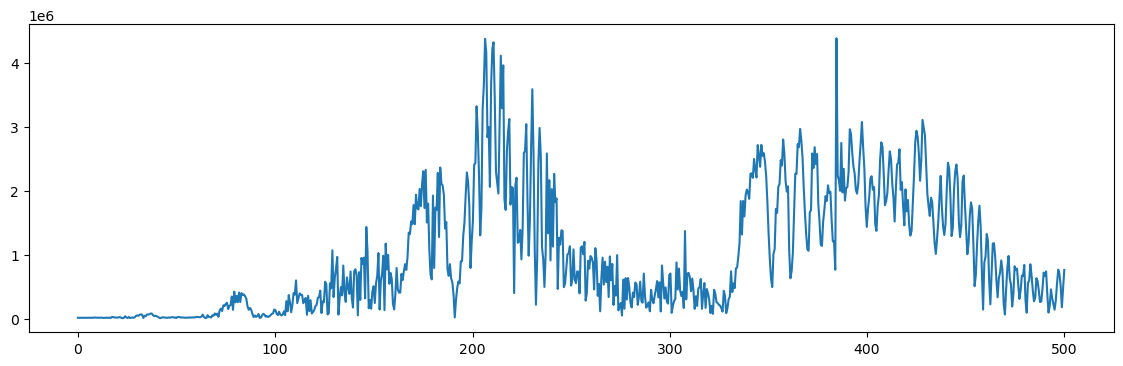

In [ ]:
importlib.reload(submitted)
yspec=submitted.todo_spectrum(y)
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(f[f<500],yspec[f<500])


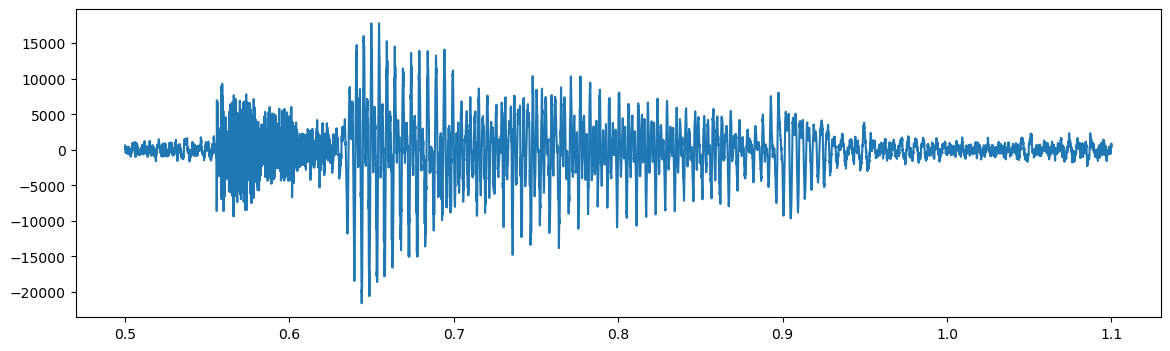

In [ ]:
t = np.linspace(0,nsamps/fs,nsamps)
fig=plt.figure(figsize=(14,4))
ax=fig.subplots()
ax.plot(t[(0.5<t)&(t<1.1)],y[(0.5<t)&(t<1.1)])

In [ ]:
import IPython.display as ipd
ipd.Audio(y, rate=fs)

## Part 4: Resonance

Bells, chimes, and similar musical instruments are created from bits of metal or wood that are each carved so that when a musician hits the bell with a stick, it rings at all of the resonant frequencies, all at once.  Usually, all of the resonant frequencies have different decay times, so that the spectral composition of the bell changes, subtly, as it decays.

The sound of a stick hitting something a hard object is pretty well described by $x[n]=\delta[n]$.   The sound of a bell being rung is therefore pretty well described as $h[n]$, its impulse response.

We already know how to convert frequency and bandwidth into poles, and we know how to creates poles into coefficients.  For a bell, however, the "bandwidth" of each pole is not so obvious.  It's usually more intuitive to talk about the **decay time** of the bell, which is the time, in seconds, after which the resonant amplitude has decayed by a factor of $e^{-1}$.  Let's first see how to compute the poles from the decay time.

In [ ]:
importlib.reload(submitted)
help(submitted.todo_bell_pole)

Help on function todo_bell_pole in module submitted:

todo_bell_pole(sample_rate, frequency, decay_time)
    Compute the pole-pair for a damped resonator with given frequency and decay time.
    Note that bandwidth of a pole is 1/(pi * decay_time).
    
    @param:
    sample_rate (int) - sampling rate, in samples/second
    frequency (int) - frequency of the resonator, in Hertz
    decay_time (int) - decay time of the resonator, in seconds
    @return:
    p (complex 2-array) - poles in the Z plane



In [ ]:
importlib.reload(submitted)
p = submitted.todo_bell_pole(16000, 660, 0.5)
print('A bell at 660Hz with decay time 0.5s, at 16000 samples/second, has these poles:',p)
print('The decay time is:',-1/(16000*np.real(np.log(p))))
print('The center frequency is:',16000*np.imag(np.log(p))/(2*np.pi))

A bell at 660Hz with decay time 0.5s, at 16000 samples/second, has these poles: [[0.96647928+0.25625734j]
 [0.96647928-0.25625734j]]
The decay time is: [[0.5]
 [0.5]]
The center frequency is: [[ 660.]
 [-660.]]


The poles can be converted to denominator coefficients using `todo_coefficients`.  A resonator has no numerator coefficients: the simple resonator has the following system function:

$$H(z) = \frac{1}{1+a_1z^{-1}+a_2z^{-2}}$$

Note this is the same as giving the numerator coefficients $b_0=1$, $b_1=0$, and $b_2=0$.  

In [ ]:
importlib.reload(submitted)
help(submitted.todo_bell_simple)

Help on function todo_bell_simple in module submitted:

todo_bell_simple(sample_rate, frequency, decay_time, duration)
    Generate a decaying resonant impulse response at the given frequency and decay time.
    The numerator coefficients are always b = [1,0,0]
    The denominator coefficients are 
    a = todo_coefficinets(todo_bell_pole(sample_rate,frequency,decay_time))
    
    Input:
    sample_rate (integer) - sampling rate, in samples/second
    frequency (nfreqs) - frequency of the resonator, in Hertz
    decay_time (nfreqs) - decay time of the resonator, ni seconds
    duration (float) - duration of x[n], in seconds
    
    Output:
    x (array of length sample_rate*duration) - impulse response of the resonator



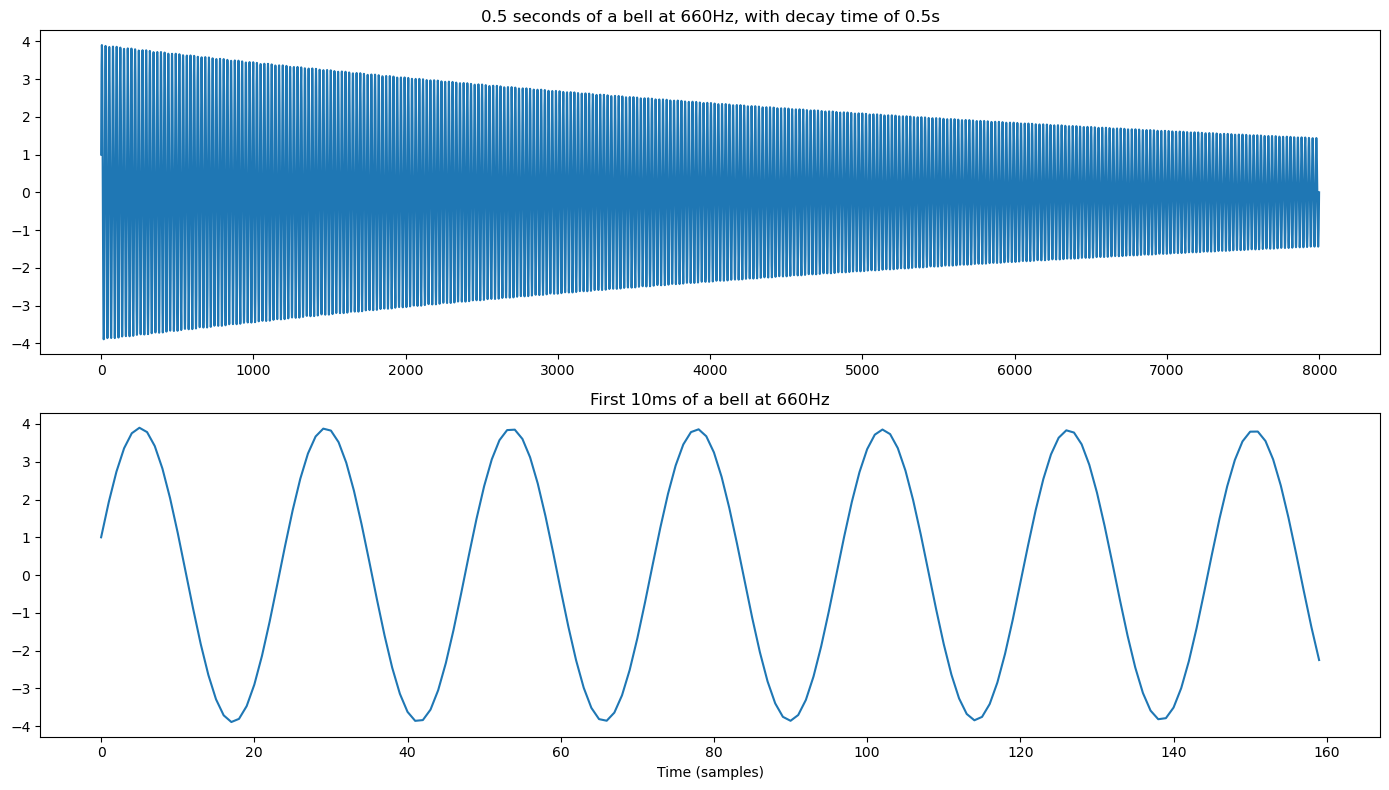

In [ ]:
importlib.reload(submitted)
x = submitted.todo_bell_simple(16000,660,0.5,0.5)

fig=plt.figure(figsize=(14,8))
ax=fig.subplots(2,1)
ax[0].plot(x)
ax[0].set_title('0.5 seconds of a bell at 660Hz, with decay time of 0.5s')
ax[1].plot(x[:160])
ax[1].set_title('First 10ms of a bell at 660Hz')
ax[1].set_xlabel('Time (samples)')
fig.tight_layout()

Finally, in order to make the bell sound more realistic, we'd like it to ring at a few different frequencies, each with a different decay time.  The resonances of a bell ring in **parallel**, so this is a parallel connection:

$$H(z) = \sum_k \frac{1}{1+a_{k,1}z^{-1}+a_{k,2}z^{-2}}$$

...where $a_{k,1}$ and $a_{k,2}$ are the coefficients corresponding to the $k^{\textrm{th}}$ resonant frequency and the $k^{\textrm{th}}$ decay time.


In [ ]:
importlib.reload(submitted)
help(submitted.todo_bell_multitone)

Help on function todo_bell_multitone in module submitted:

todo_bell_multitone(sample_rate, frequencies, decay_times, duration)
    Generate the sound of a bell ringing at several frequencies simultaneously.
    
    Input:
    sample_rate (integer) - sampling rate, in samples/second
    frequencies (nfreqs) - frequencies of the bell, in Hertz
    decay_times (nfreqs) - times after onset (in seconds) at which each tone decays to exp(-1)
    duration (float) - duration of x[n], in seconds
    
    Output:
    x (array of length sample_rate*duration) - impulse response of the bell.
      This is just the sum of the todo_bell_simple impulse responses.



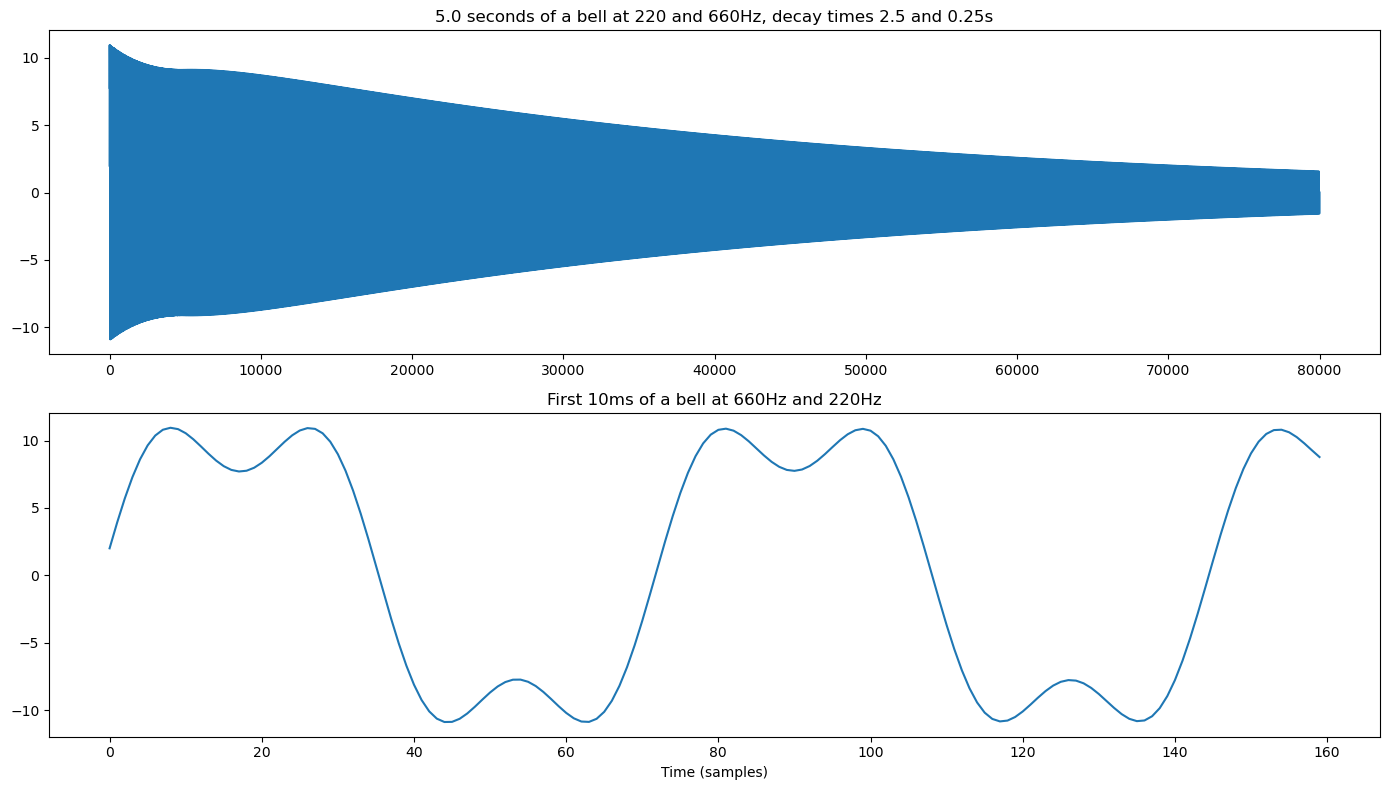

In [ ]:
importlib.reload(submitted)
bell = submitted.todo_bell_multitone(fs, [220,660], [2.5,0.25], 5.0)

fig=plt.figure(figsize=(14,8))
ax=fig.subplots(2,1)
ax[0].plot(bell)
ax[0].set_title('5.0 seconds of a bell at 220 and 660Hz, decay times 2.5 and 0.25s')
ax[1].plot(bell[:160])
ax[1].set_title('First 10ms of a bell at 660Hz and 220Hz')
ax[1].set_xlabel('Time (samples)')
fig.tight_layout()

In [ ]:
import IPython.display as ipd
ipd.Audio(bell, rate=fs)

## Extra Credit: Formant Synthesis of Speech

The extra credit assignment, for this MP, is the formant synthesis of a vowel.

A vowel is created by passing a periodic excitation signal (modeling the opening and closing of the vocal folds) through a series of formant resonators (modeling the resonant frequencies of the pharynx and mouth).  The simplest effective excitation signal is an impulse train with a period of `N0=int(sample_rate/pitch)`, thus

$$e[n] = \sum_m \delta[n-m N_0]$$


In [ ]:
import extra, importlib
importlib.reload(extra)
help(extra.todo_impulsetrain)

Help on function todo_impulsetrain in module extra:

todo_impulsetrain(sample_rate, pitch, duration)
    Create an impulse train.  Period should be the integer closest to sample_rate/pitch.
    
    @param:
    sample_rate (integer) - sampling rate, in samples/second
    pitch (integer) - pitch frequency, in Hertz
    duration (float) - duration of x[n], in seconds
    
    Output:
    impulsetrain (array, sample_rate*duration) - impulse train



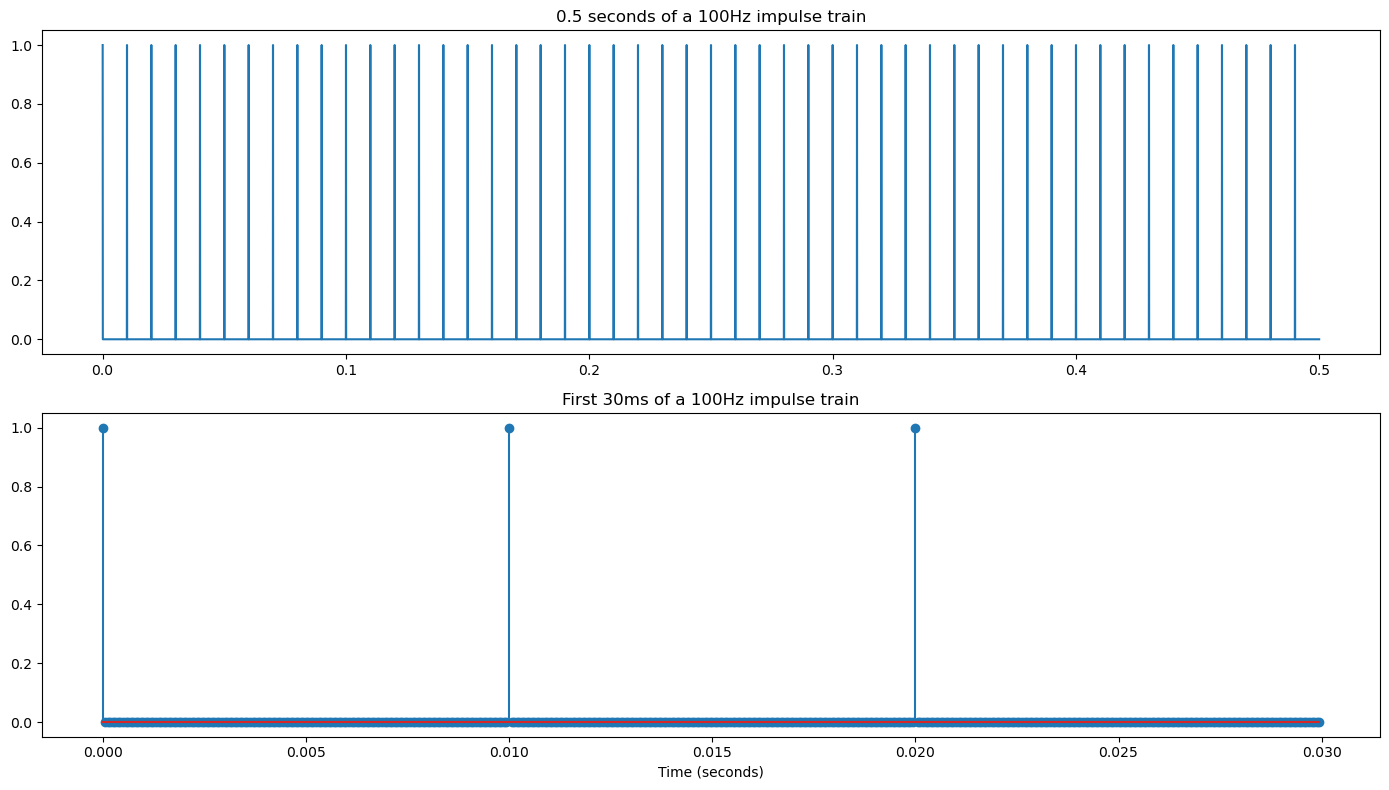

In [ ]:
importlib.reload(extra)
impulsetrain = extra.todo_impulsetrain(16000, 100, 0.5)
timeaxis = np.linspace(0,0.5,8000,endpoint=False)

fig=plt.figure(figsize=(14,8))
ax=fig.subplots(2,1)
ax[0].plot(timeaxis,impulsetrain)
ax[0].set_title('0.5 seconds of a 100Hz impulse train')
ax[1].stem(timeaxis[:480],impulsetrain[:480])
ax[1].set_title('First 30ms of a 100Hz impulse train')
ax[1].set_xlabel('Time (seconds)')
fig.tight_layout()


#### Glottal Smoother

The vocal folds don't open and close instantaneously; they have some mass.  The glottal smoother represents this delay with the filter
$$G(z) = 1-gz^{-1}$$
where the glottal pole is
$$g=e^{-\frac{\pi B_g}{F_s}}$$
The glottal bandwidth, $B_g$, is specified by the parameter `glottalbw`.



In [ ]:
importlib.reload(extra)
help(extra.todo_glottalfilter)

Help on function todo_glottalfilter in module extra:

todo_glottalfilter(x, sample_rate, glottalbw)
    Filter the input using a one-pole filter to simulate the glottal smoothing characteristic.
    
    @param:
    x (array) - input signal
    sample_rate (integer) - sampling rate, in samples/second
    glottalbw (integer) - bandwidth of the glottal smoother, in Hertz
    @return:
    y (array) - filtered signal.  y[n]=x[n]-a*y[n-1], where a is the coefficient 
      for a one-pole filter with center frequency=0Hz and with the given glottalbw.



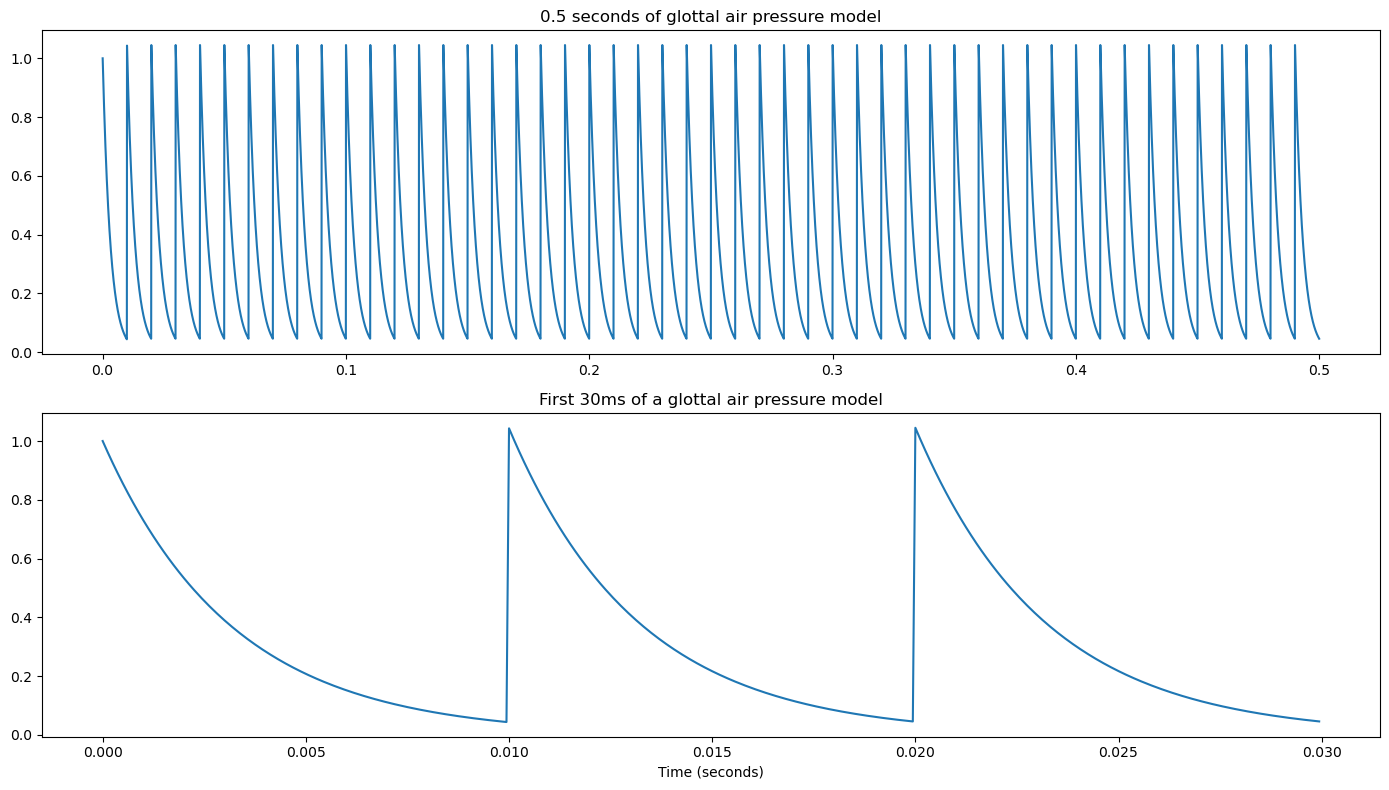

In [ ]:
importlib.reload(extra)
glottal = extra.todo_glottalfilter(impulsetrain, 16000, 100)

fig=plt.figure(figsize=(14,8))
ax=fig.subplots(2,1)
ax[0].plot(timeaxis,glottal)
ax[0].set_title('0.5 seconds of glottal air pressure model')
ax[1].plot(timeaxis[:480],glottal[:480])
ax[1].set_title('First 30ms of a glottal air pressure model')
ax[1].set_xlabel('Time (seconds)')
fig.tight_layout()

#### Formant Resonators

Most of the information in the vowel is provided by formant resonators.  The $k^{\textrm{th}}$ formant resonator has the following denominator:
$$A_k(z) = (1-p_kz^{-1})(1-p_k^*z^{-1}) = 1+a_{1,k}z^{-1}+a_{2,k}z^{-2}$$

The poles are given in terms of the formant frequencies and bandwidths as

$$p_k = e^{-\sigma_k+j\omega_k}$$

where

$$\sigma_k = \frac{\pi B_k}{F_s},~~~\omega_k=\frac{2\pi F_k}{F_s}$$

In [ ]:
importlib.reload(extra)
help(extra.todo_formant_resonator)

Help on function todo_formant_resonator in module extra:

todo_formant_resonator(x, sample_rate, formant, bandwidth)
    Filter the input through a two-pole resonator with center frequency at the formant,
    and with the given bandwidth.
    
    @param:
    x (array) - input signal
    sample_rate (integer) - sampling rate, in samples/second
    formant (int) - formant frequency, in Hertz
    bandwidht (int) - formant bandwidth, in Hertz
    @return:
    y (array) - filtered signal.  y[n]=x[n]-a[1]*y[n-1]-a[2]*y[n-2], where a are the coefficients
      for a two-pole filter at the given formant frequency and bandwidth.



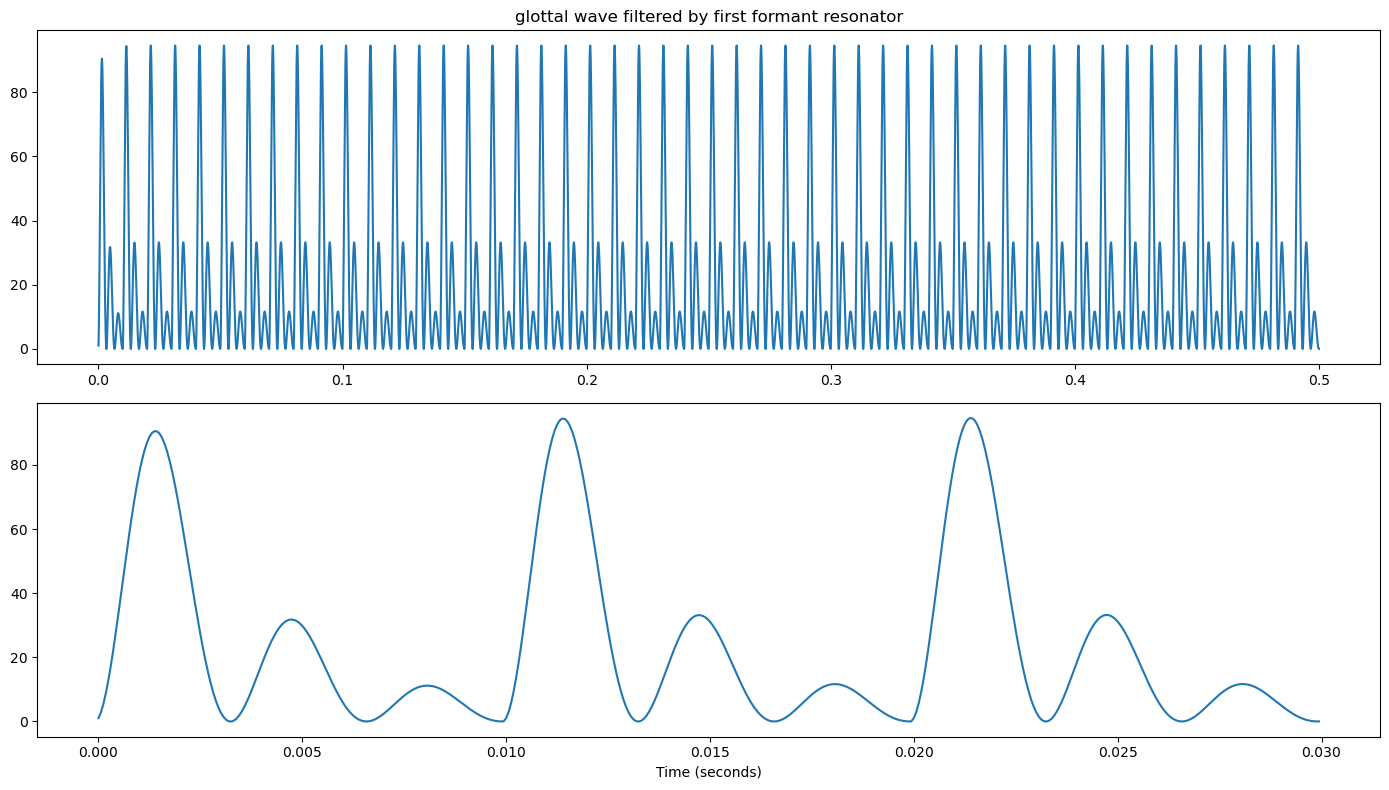

In [ ]:
importlib.reload(extra)
h1 = extra.todo_formant_resonator(glottal, 16000, 300, 100)

fig=plt.figure(figsize=(14,8))
ax=fig.subplots(2,1)
ax[0].plot(timeaxis,h1)
ax[0].set_title('glottal wave filtered by first formant resonator')
ax[1].plot(timeaxis[:480],h1[:480])
ax[1].set_xlabel('Time (seconds)')
fig.tight_layout()

In order to synthesize speech, we generate the impulse train $e[n]$, then pass it through the glottal smoother and four consecutive formant resonators.  Notice this is a **series** connection, unlike the synthesis of a bell.

$$e[n]\rightarrow\frac{1}{G(z)}\rightarrow\frac{1}{A_1(z)}\rightarrow \frac{1}{A_2(z)}\rightarrow \frac{1}{A_3(z)}\rightarrow \frac{1}{A_4(z)}\rightarrow s[n]$$


In [ ]:
import extra
importlib.reload(extra)
help(extra.todo_speech)

Help on function todo_speech in module extra:

todo_speech(sample_rate, pitch, glottalbw, formants, bandwidths, duration)
    Synthesize a vowel with specified pitch frequency, formants, and formant bandwidths.
    
    Input:
    sample_rate (integer) - sampling rate, in samples/second
    pitch (integer) - pitch frequency, in Hertz
    glottalbw (integer) - bandwidth of the glottal smoother, in Hertz
    formants (nfreqs) - formant frequencies, in Hertz
    bandwidhts (nfreqs) - formant bandwidths, in Hertz
    duration (float) - duration of x[n], in seconds
    
    Output:
    speech (array sample_rate*duration) - the synthetic vowel.
      First, create the impulse train.
      Second, filter it through the glottal resonator.
      Third, filter it through the first formant resonator.
      Fourth, filter it through the second formant resonator.
      ... and so on ...
      Note: we are connecting all the resonators in __series__.
      This differs from the submitted.todo_bell_m

In [ ]:
importlib.reload(extra)
sample_rate = 16000
duration = 0.5
glottal = 100
formants = [300, 2000, 2700, 3500]
bandwidths = [100, 200, 300, 700]
pitch = 125
speech = extra.todo_speech(sample_rate,pitch, glottal, formants, bandwidths,duration)
print('Speech signal has length',len(speech),'and its first samples are',speech[:10])

Speech signal has length 8000 and its first samples are [ 1.          5.54924537 15.64647118 29.54617844 41.85550221 48.06057486
 48.97846322 50.15317586 56.72398768 69.0230751 ]


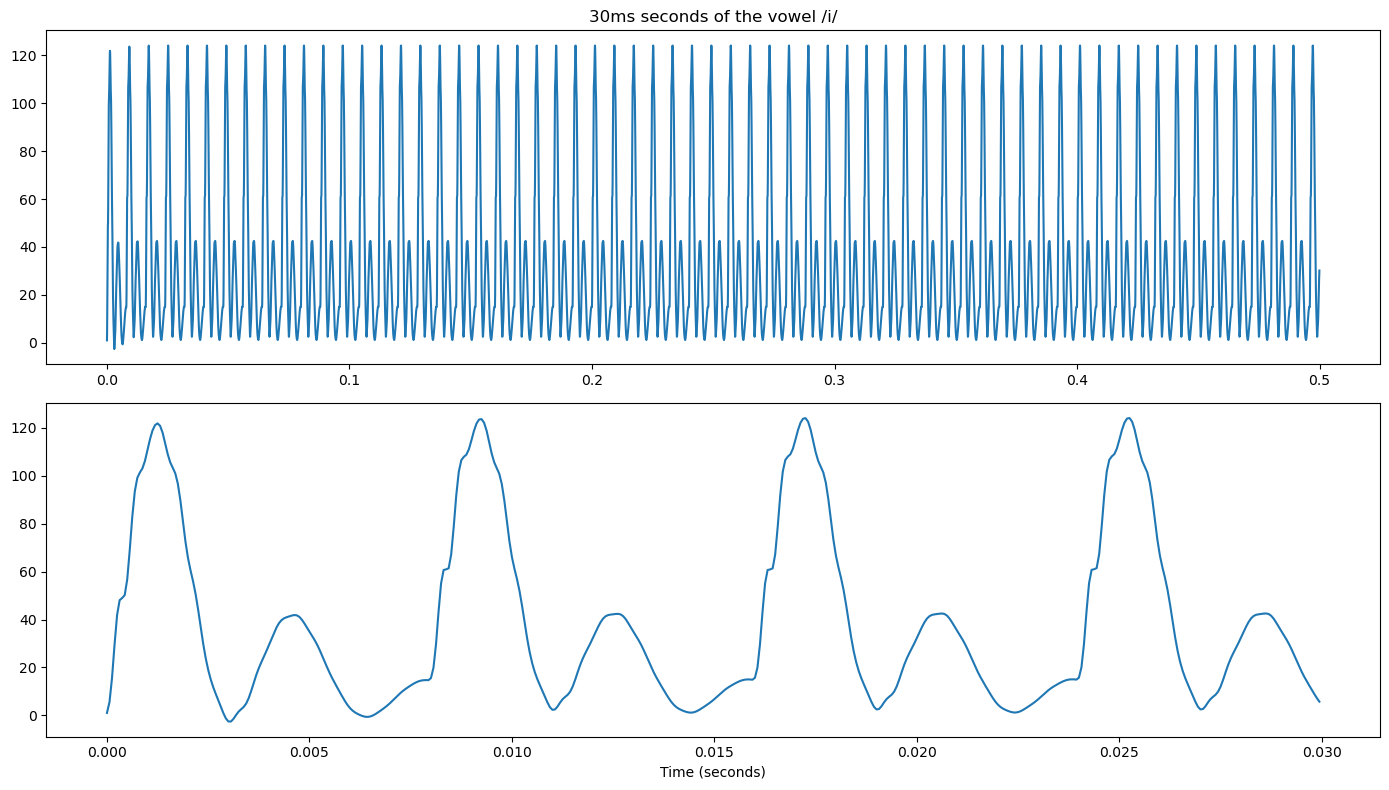

In [ ]:
fig=plt.figure(figsize=(14,8))
ax=fig.subplots(2,1)
ax[0].plot(timeaxis,speech)
ax[0].set_title('0.5 seconds of the vowel /i/')
ax[1].plot(timeaxis[:480],speech[:480])
ax[0].set_title('30ms seconds of the vowel /i/')
ax[1].set_xlabel('Time (seconds)')
fig.tight_layout()

In [ ]:
import IPython.display as ipd
ipd.Audio(speech, rate=sample_rate)

If you have a little extra time, consider testing the different formant frequencies listed here: https://en.wikipedia.org/wiki/Formant